# A/B тестирование

# Описание проекта

- Заказчик проекта — отдел маркетинга крупного интернет-магазина 
- Задача проекта — приоритизировать существующие гипотезы, запустить A/B тест и провести анализ получившихся результатов.

# Описание данных для первой части проекта
Файл - /datasets/hypothesis.csv:

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.



# Описание данных для второй части проекта
Файл - /datasets/orders.csv:

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.


Файл - /datasets/visitors.csv:

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

# Содержание проекта:

1. [Шаг 1. Загрузка датасета и подготовка его к анализу](#start)
    * [Выводы](#start_conclusion)


2. [Шаг 2. Приоритизация гипотез](#prioritization)
    * [Выводы](#prioritization_conclusion)


3. [Шаг 3. Анализ A/B-теста](#A/B_test)
    * [Выводы](#A/B_test_conclusion)


4. [Выводы](#conclusion)

## Шаг 1. Загрузка датасета и подготовка его к анализу<a id="start"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import datetime as dt
import scipy.stats as stats

# <Убираем предупреждения>
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")


# Используем set_option для того, чтобы полностью отобразить гипотезы в датафрейме     
pd.set_option("max_colwidth", 150)

In [2]:
hypothesis = pd.read_csv('.../hypothesis.csv')

orders = pd.read_csv('.../orders.csv')

visitors = pd.read_csv('.../visitors.csv')

# <Меняем регистр названий столбцов>
hypothesis.columns = map(str.lower, hypothesis.columns)
orders.columns = map(str.lower, orders.columns)
visitors.columns = map(str.lower, visitors.columns)

In [4]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
orders

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [6]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [7]:
# <Переименовываем названия столбцов для удобства>
orders = orders.rename(columns={'transactionid': 'transaction_id', 'visitorid': 'visitor_id'})
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [8]:
print('Количество дубликатов в таблице visitors:', visitors.duplicated(keep = False).sum())
print('Количество дубликатов в таблице orders:', orders.duplicated(keep = False).sum())
print('Количество дубликатов в таблице hypothesis:', hypothesis.duplicated(keep = False).sum())

Количество дубликатов в таблице visitors: 0
Количество дубликатов в таблице orders: 0
Количество дубликатов в таблице hypothesis: 0


### Выводы<a id="start_conclusion"></a>

- Переименовали столбы и привели их названия к нижнему регистру
- Дубликатов и пропусков в таблицах visitors, orders и hypothesis не обнаружили

## Шаг 2. Приоритизация гипотез<a id="prioritization"></a>

In [9]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

$$ICE = \frac{Impact * Confidence}{Efforts}, где $$


- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта
- Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так
- Efforts — сколько стоит протестировать эту гипотезу

In [10]:
# <ICE>

hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'ICE']].sort_values(by = 'ICE', ascending = False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Согласно ICE наиболее приоритетными гипотезами являются:
- 8 (акция, дающая скидку в день рождения), 
- 0 (добавление двух новых каналов привлечения трафика)
- 7 (форма подписки на основные страницы)
- 6 (показ баннеров на главной странице сайта)

### Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts} , где$$

- Reach — скольких пользователей затронет изменение
- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта
- Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так
- Efforts — сколько стоит протестировать эту гипотезу

In [11]:
# <RICE>

hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

hypothesis[['hypothesis', 'RICE']].sort_values(by = 'RICE', ascending = False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Согласно RICE наиболее приоритетными гипотезами являются:
- 7 (форма подписки на основные страницы), 
- 2 (добавление блоков рекомендаций на сайт)
- 0 (добавление двух новых каналов привлечения трафика)
- 6 (показ баннеров на главной странице сайта)

### Выводы<a id="prioritization_conclusion"></a>

Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

Приоритизация гипотез при применении RICE поменялась: 

- из-за того, что гипотеза 8 (про скидку на день рождения) охватывает лишь небольшую часть посетителей, она по приоритетности спустилась на пятую строчку в рейтинге
- гипотеза 0 (про добавление двух новых каналов привлечения трафика) спустилась на третью позицию из-за того, что ее охват один из самых маленьких (равен 3)
- у гипотезы 7 (про форму подписки на основные страницы) наибольший охват (10), поэтому в RICE она заняла первую строчку
- гипотеза 6 (про показ баннеров на главной странице сайта) осталась на прежнем 4ом месте
- у гипотезы 2 (про добавление блоков рекомендаций на сайт) второй по величине охват, поэтому она заняла второе место по приоритизации в RICE

Наибольшее внимание стоит обратить на гипотезы 7, 0, и 8

Гипотезы 2 и 6 имеют маленькое влияние на пользователей продукта, поэтому не следует считать их одними из приоритетных

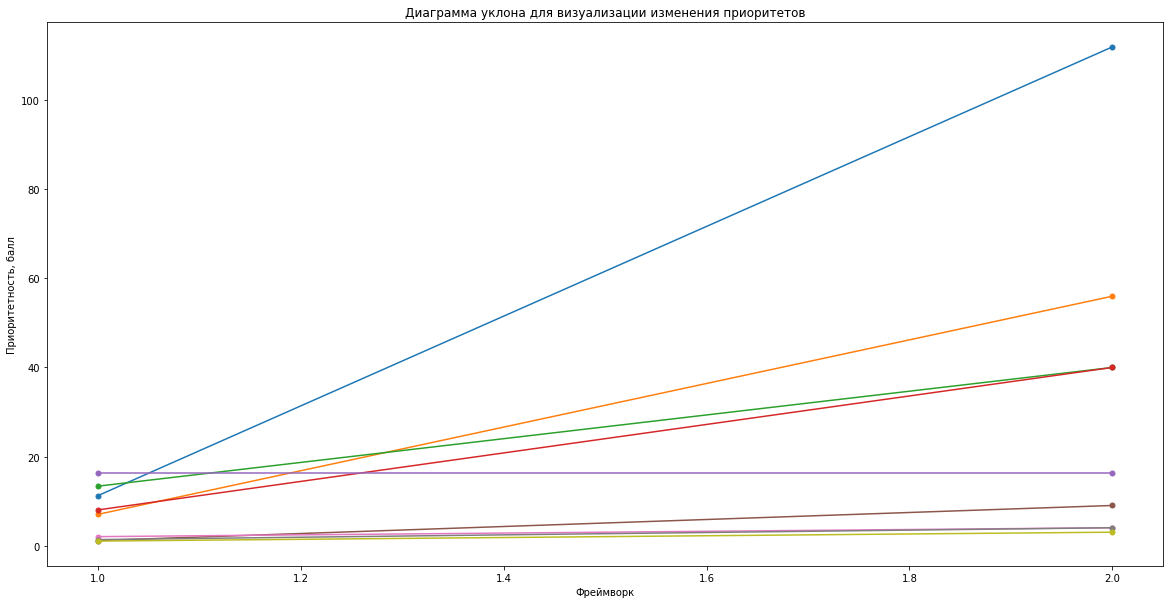

In [12]:
# <Построим диаграмму уклона для визуализации изменения приоритетов>

hypothesis_name = ['Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
             'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
             'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
             'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
             'Запустить акцию, дающую скидку на товар в день рождения', 
             'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
             'Запустить собственную службу доставки, что сократит срок доставки заказов',
             'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
             'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей'
            ]

fig, ax = plt.subplots(1, figsize=(20,10))
for i in hypothesis_name:
    
    temp = hypothesis[hypothesis['hypothesis'] == i]
    
    plt.title('Диаграмма уклона для визуализации изменения приоритетов')  
    plt.ylabel('Приоритетность, балл')
    plt.xlabel('Фреймворк')
    plt.plot( [1,2], [temp.ICE, temp.RICE], marker='o', markersize=5, label = i)

plt.show()

## Шаг 3. Анализ A/B-теста<a id="A/B_test"></a>

In [13]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [14]:
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [15]:
# <Смотрим процентное соотношение пользователей, попавших в две группы: и A, и B>

orders_query_2_group = orders.pivot_table(index = 'visitor_id', values = 'group', aggfunc = 'count').reset_index()
orders_query_2_group = orders_query_2_group.query('group == 2')


print((orders_query_2_group['group'].count())/(orders['group'].count())*100)

print(
    'Таких пользователей около 5%, не удаляем их из orders: поскольку их мало, они не сильно повлияют на конверсию в visitors'
)

5.3467000835421885
Таких пользователей около 5%, не удаляем их из orders: поскольку их мало, они не сильно повлияют на конверсию в visitors


### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null int64
visitor_id        1197 non-null int64
date              1197 non-null object
revenue           1197 non-null int64
group             1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [17]:
# <Приводим столбцы date таблиц orders и visitors к формату  %Y-%m-%d> 

orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)


visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [18]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

In [19]:
# <Получаем строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups, 
# а группа теста равна группе из datesGroups:>

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and
                                                      (orders['date'] <= x['date'], 
                                                       orders['group'] == x['group'])]\
                                     
# <Агрегируем значения, вычисляем максимальную дату. Для группы рассчитываем максимум,чтобы она не пропала из вывода.
# Находим число уникальных ID заказов и ID пользователей. Считаем сумму средних чеков>
                                     
                                     .agg({'date' : 'max', 
                                           'group' : 'max', 
                                           'transaction_id' : pd.Series.nunique, 
                                           'visitor_id' : pd.Series.nunique, 
                                           'revenue' : 'sum'}), 
                                     
# <Применяем методы к каждой строке датафрейма: apply(axis=1)>                                    
                                     axis=1
                                     
# <Сортируем результаты по столбцам 'date' и 'group'> 
                                    ).sort_values(by=['date','group'])

# <Получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина>
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and 
                                                          (visitors['date'] <= x['date'], 
                                                           visitors['group'] == x['group'])]\
                                       .agg({'date' : 'max', 
                                             'group' : 'max', 
                                             'visitors' : 'sum'
                                            }), axis=1
                                      ).sort_values(by=['date','group'])

In [20]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, 
                                        left_on=['date', 'group'], 
                                        right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


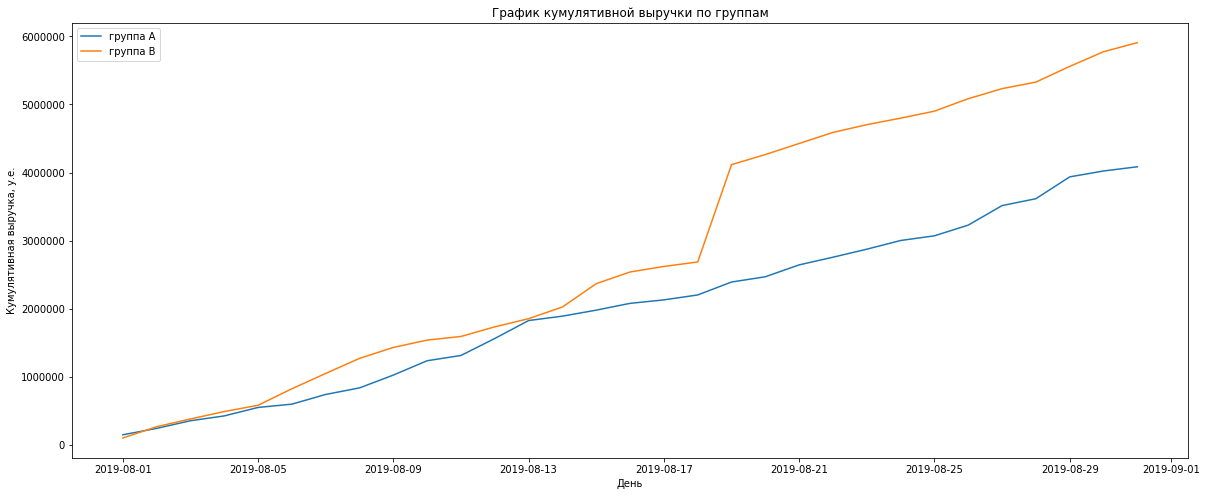

In [21]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]


# Строим график выручки группы А
plt.figure(figsize=(20, 8))
plt.title('График кумулятивной выручки по группам')
plt.ylabel('Кумулятивная выручка, у.е.')
plt.xlabel('День')

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='группа A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='группа B')

plt.legend()
plt.show()

- Выручка почти равномерно увеличивается в течение всего теста
- В нескольких точках графики выручки резко растут - это может говорить о резком увеличении числа заказов или о появлении очень дорогих заказов в выборке

### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.


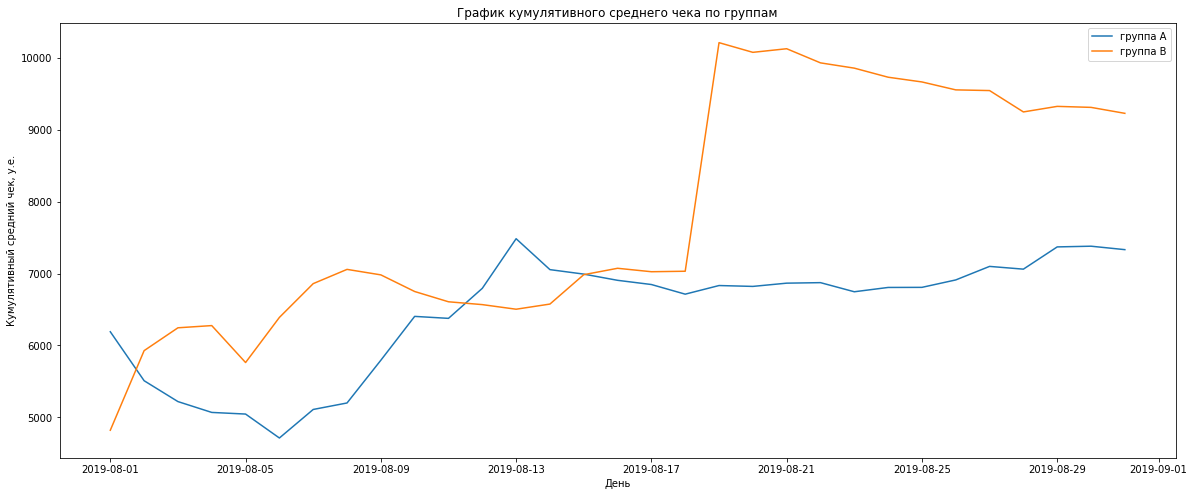

In [22]:
# <Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов>

plt.figure(figsize=(20, 8))

plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Кумулятивный средний чек, у.е.')
plt.xlabel('День')

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='группа B')

plt.legend() 
plt.show()

Средний чек становится более равномерным к концу теста: 
- после резкого скачка среднего чека группы B 18 августа его значения постепенно снижаются, но все равно остаются значительно выше среднего чека группы A.
- возможно, из-за резкого скачка нужно больше данных, чтобы прийти к реальному среднему чеку.

### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.


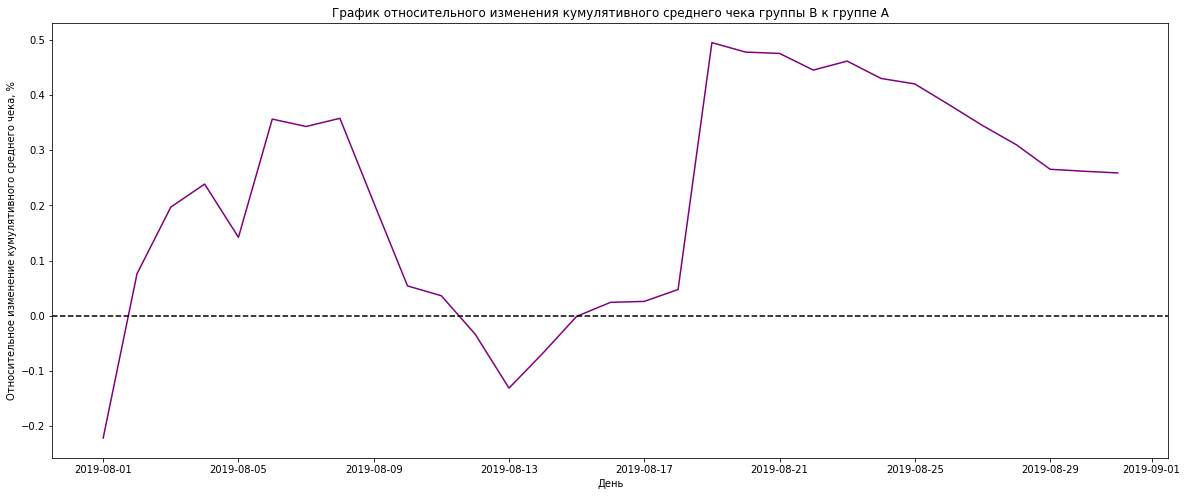

In [23]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])

# cтроим отношение средних чеков

plt.figure(figsize=(20, 8))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel('Относительное изменение кумулятивного среднего чека, %')
plt.xlabel('День')

plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1, color="purple")

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

- В самом начале теста группа B проигрывала группе A, затем вырвалась вперёд. 13 августа снова падал средний чек группы B относительно среднего чека группы A, зато 18 августа он резко увеличился и остается на уровне выше 0,25.

- В целом отношение среднего чека ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя - сперва стоит проанализировать аномально крупные заказы и выбросы, из-за которых в нескольких точках график различия между группами резко «скачет».

### Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.


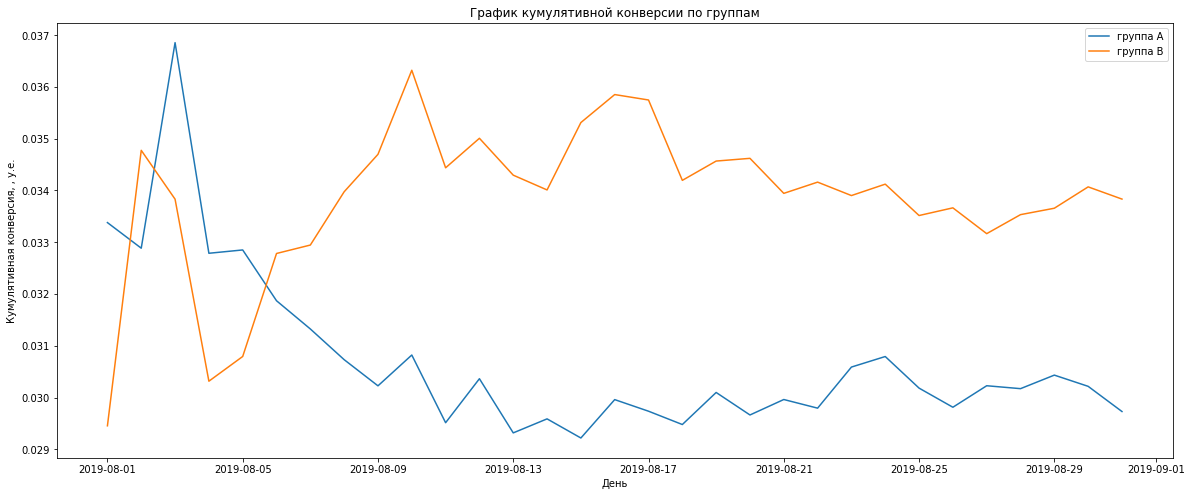

In [24]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(20, 8))
plt.title('График кумулятивной конверсии по группам')
plt.ylabel('Кумулятивная конверсия, , у.е.')
plt.xlabel('День')


plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='группа B')
plt.legend()



- Получился почти симметричный график кумулятивной конверсии по группам.
- В начале теста группы колебались около значения 0.33, но затем конверсия группы B увеличилась и зафиксировалась на уровне 0.34, а конверсия группы A просела и также зафиксировалась на уровне ниже 0,31.

### Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.


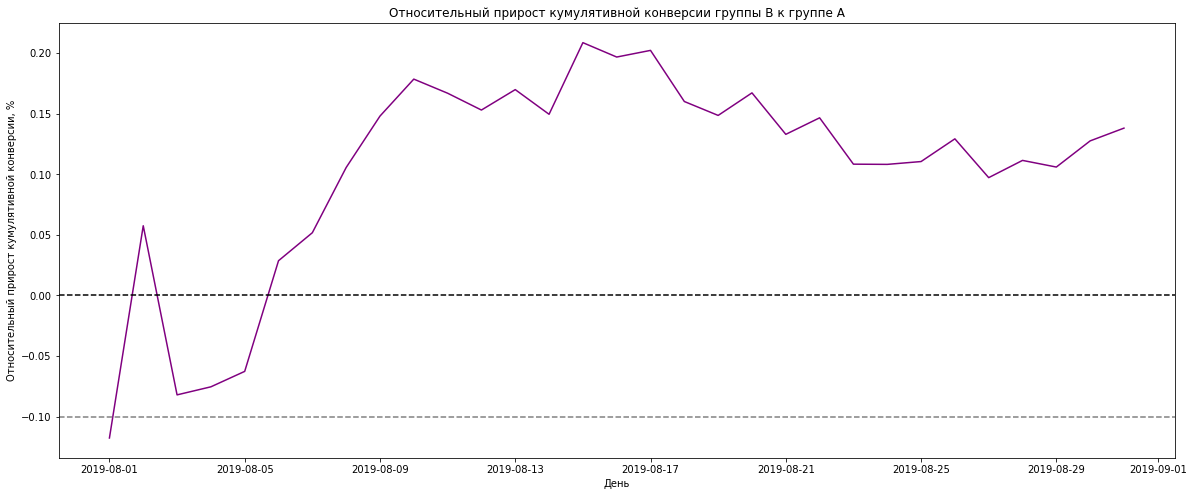

In [25]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

# строим графики

plt.figure(figsize=(20, 8))
plt.title('Относительный прирост кумулятивной конверсии группы B к группе A')
plt.ylabel('Относительный прирост кумулятивной конверсии, %')
plt.xlabel('День')

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, color="purple")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

В первые 5 дней теста группа A с переменным успехом выигрывала у группы B, однако с 5 августа группа B вырвалась вперед и ее относительная конверсия увеличилась относительно группы A и зафиксировалась.

Следует проанализировать аномалии.

### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.


In [26]:
# <Создаем таблицу с количеством заказов на каждого пользователя, чтобы найти аномально большое количество заказов>

ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

ordersByUsers.columns = ['visitor_id', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Есть пользователи, которые совершали 5, 8, 9 и 11 заказов. Значительно больше, чем обычный пользователь

(array([937.,  64.,  17.,   3.,   6.,   0.,   0.,   1.,   1.,   2.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 10 Patch objects>)

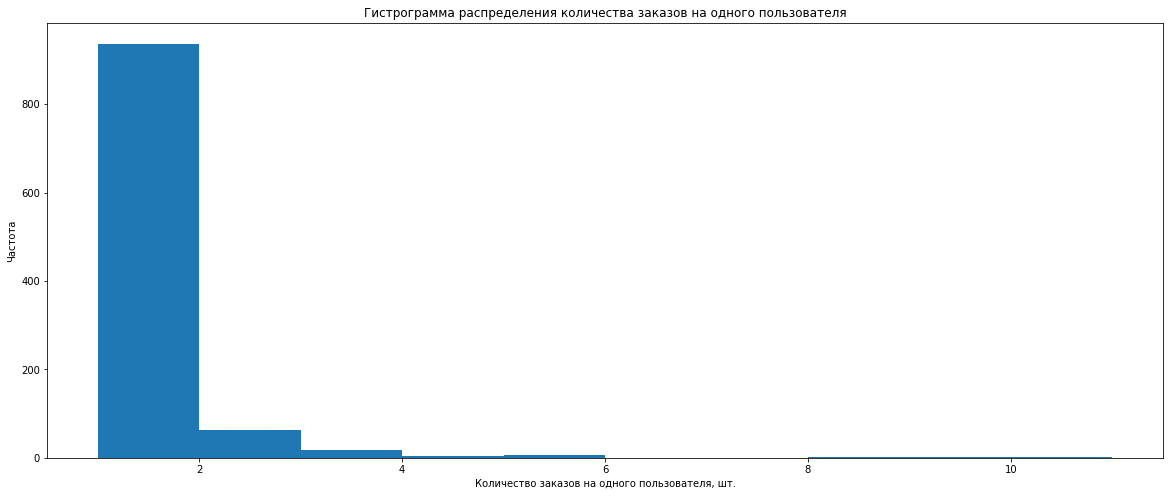

In [27]:
# <Построим гистрограмму распределения количества заказов на одного пользователя>

plt.figure(figsize=(20, 8))
plt.title('Гистрограмма распределения количества заказов на одного пользователя')
plt.ylabel('Частота')
plt.xlabel('Количество заказов на одного пользователя, шт.')

plt.hist(ordersByUsers['orders']) 

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-4 заказами тоже значительна.

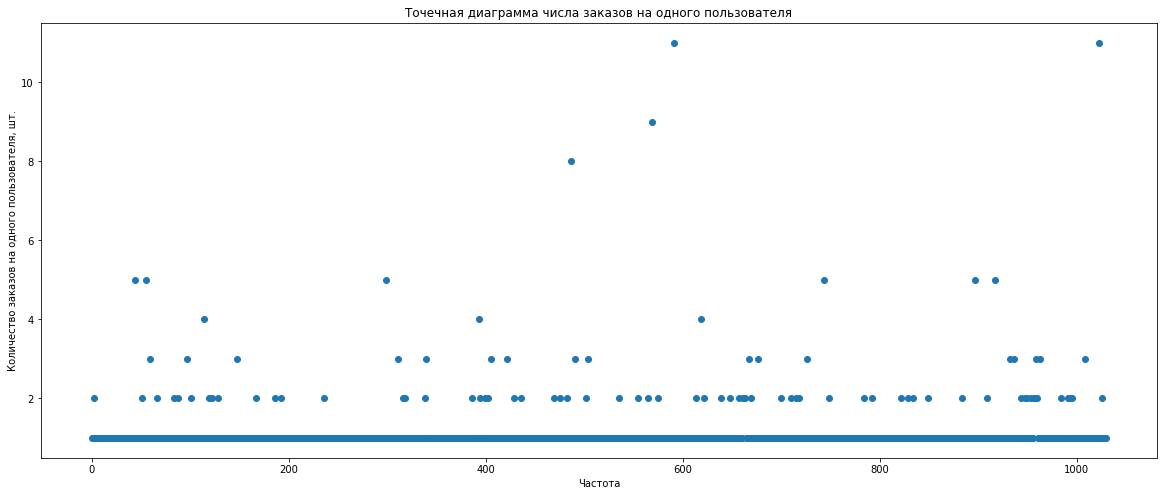

In [28]:
# <Построим точечную диаграмму числа заказов на одного пользователя>

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(20, 8))
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.ylabel('Количество заказов на одного пользователя, шт.')
plt.xlabel('Частота')

plt.scatter(x_values, ordersByUsers['orders'] )

Выводы подтверждаются: много пользователей с 2-4 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет.

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.


In [29]:
# Посчитаем выборочные перцентили количества заказов на одного пользователя:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей оформляли заказы больше 2 раз. И только 1% пользователей делали заказы более 4 раз.
За верхнюю границу числа заказов следует принять 2 заказа, и отсеять аномальных пользователей.

### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.


(array([1.195e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([5.000000e+01, 1.294950e+05, 2.589400e+05, 3.883850e+05,
        5.178300e+05, 6.472750e+05, 7.767200e+05, 9.061650e+05,
        1.035610e+06, 1.165055e+06, 1.294500e+06]),
 <a list of 10 Patch objects>)

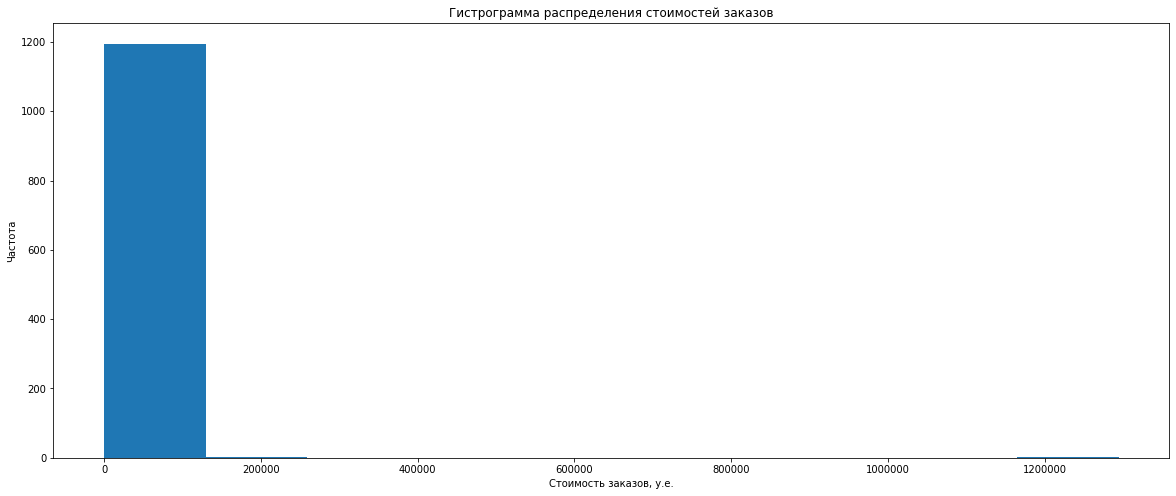

In [30]:
# <Построим гистрограмму распределения стоимостей заказов>

plt.figure(figsize=(20, 8))
plt.title('Гистрограмма распределения стоимостей заказов')
plt.ylabel('Частота')
plt.xlabel('Стоимость заказов, у.е.')

plt.hist(orders['revenue'])

Есть заказы дороже 1200 000, но большинство всё-таки имеет выручку меньше 100 000.

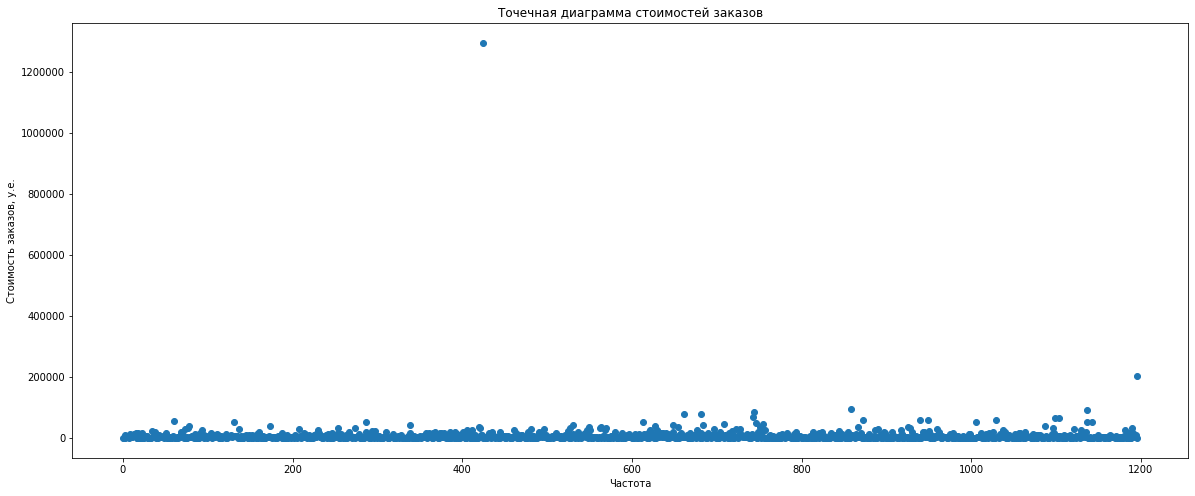

In [31]:
# <Построим точечную диаграмму стоимостей заказов>

x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(20, 8))
plt.title('Точечная диаграмма стоимостей заказов')

plt.xlabel('Частота')
plt.ylabel('Стоимость заказов, у.е.')
#plt.ylim(0, 100000)
plt.scatter(x_values, orders['revenue']) 

- На графике видны два дорогих заказа: на уровне 200 000 и на уровне 1200 000. 
- Выберем более точные аномальные значения с помощью перцентилей

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.


In [32]:
# Посчитаем выборочные перцентили стоимости заказов:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


- Перцентили стоимости заказов - не более 5% заказов дороже 28000 рублей и не более 1% дороже 58233 рублей.
- Возьмем за границу аномальных значений 28 000 рублей

### Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.


Формулировка гипотез по конверсии

- Гипотеза H₀: "Между группами A и B нет статистически значимых различий в конверсии".
- Гипотеза H₁: "Между группами A и B есть статистически значимые различия в конверсии".

Формулировка гипотез по среднему чеку

- Гипотеза H₀: "Между группами A и B нет статистически значимых различий в среднем чеке".
- Гипотеза H₁: "Между группами A и B есть статистически значимые различия в среднем чеке".

In [33]:
# <Создаем таблицу со столбцом visitorsPerDateA — количество пользователей в выбранную дату в группе A>
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# <Создаем таблицу со столбцом visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A>
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# <Создаем таблицу со столбцом visitorsPerDateB — количество пользователей в выбранную дату в группе B>
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# <Создаем таблицу со столбцом visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B>
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# <Создаем таблицу со столбцами ordersPerDateA (количество заказов в выбранную дату в группе A)
# и revenuePerDateA — (суммарная выручка в выбранную дату в группе A) >
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# <Создаем таблицу со столбцами ordersCummulativeA (суммарное число заказов до выбранной даты включительно в группе A)
#  и revenueCummulativeA (суммарная выручка до выбранной даты включительно в группе A)>
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# <Создаем таблицу со столбцами ordersPerDateB (количество заказов в выбранную дату в группе B)
# и revenuePerDateB — (суммарная выручка в выбранную дату в группе B) >
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# <Создаем таблицу со столбцами ordersCummulativeB (суммарное число заказов до выбранной даты включительно в группе B)
#  и revenueCummulativeB (суммарная выручка до выбранной даты включительно в группе B)>
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# <Соединяем созданные выше таблицы в одну таблицу data>
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [34]:
# <Создадим ordersByUsersA и ordersByUsersB: для пользователей, которые заказывали хотя бы 1 раз, укажем число заказов>
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

In [35]:
# <Создаем переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов>
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


# <Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой>
print('P-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))



# <Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1>
print('Относительный прирост конверсии группы B:',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


alpha = 0.05  # критический уровень статистической значимости,если p-value окажется меньше него - отвергнем гипотезу
results_conversion_raw = stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided').pvalue
print()
if results_conversion_raw < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-value: 0.017
Относительный прирост конверсии группы B: 0.138

Отвергаем нулевую гипотезу


По «сырым данным» есть существенные статистически значимые различия в конверсии групп A и B: поскольку P-value значительно ниже 0,05, нулевую гипотезу отвергаем.

Относительный прирост конверсии группы B к группе A равен 13,8%

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.


In [36]:
# <Передадим критерию данные о выручке с заказов, чтобы рассчитать статистическую значимость различий в среднем чеке>
print('P-value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                                      orders[orders['group']=='B']['revenue'], alternative='two-sided')[1]
                                  )
     )

print('Относительный прирост среднего чека группы B:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/
                                                                       orders[orders['group']=='A']['revenue'].mean()-1))

alpha = 0.05  # критический уровень статистической значимости,если p-value окажется меньше него - отвергнем гипотезу
results_revenue_raw = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                                      orders[orders['group']=='B']['revenue'], alternative='two-sided').pvalue
print()
if results_revenue_raw < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-value: 0.729
Относительный прирост среднего чека группы B: 0.259

Не получилось отвергнуть нулевую гипотезу


Первое число — p-value = 0.365, и оно больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в средних чеках между группами нет, не отвергаем. 

Относительный выигрыш группы B равен 25,9%, то есть средний чек группы B значительно выше среднего чека группы A.

### Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.


Примем за аномальных пользователей тех, кто совершил от 2 (не включая) заказов или совершил заказ дороже 28 000 рублей. Так мы уберём от 1% до 5% пользователей с наибольшим числом заказов и 5% пользователей с дорогими заказами. 

Сделаем срезы пользователей:
- с числом заказов больше 2 — usersWithManyOrders,
- совершивших заказы дороже 28 000 — usersWithExpensiveOrders. 

In [37]:
# <Создаем срезы пользователей>
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']

# <Объединяем срезы пользователей>
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

abnormalUsers.head(5)

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64

In [38]:
# <Узнаем, сколько всего аномальных пользователей методом shape().>
abnormalUsers.shape

(74,)

Всего 74 аномальных пользователя

In [39]:
# <Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным>

# <Создаем очищенные переменные sampleA и sampleB>

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [40]:
print('P-value:','{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative='two-sided')[1]))
print('Относительный прирост конверсии группы B на очищенных данных:','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

alpha = 0.05  # критический уровень статистической значимости,если p-value окажется меньше него - отвергнем гипотезу
results_conversion = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative='two-sided').pvalue
print()
if results_conversion < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-value: 0.013
Относительный прирост конверсии группы B на очищенных данных: 0.173

Отвергаем нулевую гипотезу


Все еще есть существенные статистически значимые различия в конверсии групп A и B: поскольку P-value значительно ниже 0,05, нулевую гипотезу отвергаем.

По «очищенным данным» значения конверсия изменились: 
- Относительный прирост конверсии группы B к группе A после очистки данных от аномалий увеличился с 13,8% до 17,3% - на 3,5%.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.


In [41]:
print('P-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            alternative='two-sided'
        )[1]
    )
)

print('Относительный прирост среднего чека группы B на очищенных данных:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)


alpha = 0.05  # критический уровень статистической значимости,если p-value окажется меньше него - отвергнем гипотезу
results_revenue = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            alternative='two-sided'
        ).pvalue
print()
if results_revenue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-value: 0.738
Относительный прирост среднего чека группы B на очищенных данных: -0.020

Не получилось отвергнуть нулевую гипотезу


P-value увеличился с 0,365 до 0,369, но разница между сегментами резко сократилась с 25,9% до -2%.

Таким образом общие выводы изменились: средний чек группы B относительно среднего чека группы A на очищенных данных проигрывает 2%

### Выводы<a id="A/B_test_conclusion"></a>

- Есть статистически значимое различие по конверсии между группами и по «сырым» данным (P-value = 0.017), и по данным после фильтрации аномалий (P-value = 0.013);
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым» данным (P-value = 0.729), ни по данным после фильтрации аномалий (P-value = 0.738);
- Относительный прирост конверсии группы B к группе A после очистки данных от аномалий равен 17,3%;
- Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Продолжать смысла нет, потому как вероятность, что при имеющихся данных сегмент B станет хуже сегмента A — практически нулевая.

# Выводы <a id="conclusion"></a>

Приоритизация гипотез:
- Наибольшее внимание стоит обратить на гипотезы 7, 0, и 8
- Гипотезы 2 и 6 имеют маленькое влияние на пользователей продукта, поэтому не следует считать их одними из приоритетных

Анализ A/B теста:
- Есть статистически значимое различие по конверсии между группами и по «сырым» данным, и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым» данным, ни по данным после фильтрации аномалий;
- График различия конверсии между группами показывает, что результаты группы B лучше группы A и есть значительная тенденция к улучшению;
- График различия среднего чека сильно колеблется: он позволил найти аномалии. Сделать из этого графика определённые выводы нельзя;
- Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Продолжать смысла нет, потому как вероятность, что при имеющихся данных сегмент B станет хуже сегмента A — практически нулевая.

Таким образом, решением данного A/B теста будет победа группы B 